<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/evolution_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [332]:
# !pip install python-dotenv

from dotenv import load_dotenv

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from copy import deepcopy
sns.set()


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)


In [333]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))





seaborn==0.11.1
pandas==1.1.5
numpy==1.19.5
matplotlib==3.2.2
google==2.0.3


In [334]:
google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
load_dotenv(google_drive_dir + '.env')

True

         High       Low     Close     BTC volume  Number of trades  BTC buy volume  USDT sell volume  Buy / volume ratio  Sell / volume ratio      3 MA      7 MA     25 MA     99 MA
99   1.018132  1.023635  1.013489   62134.750663          906111.0    31911.708832      3.789059e+08            0.513589             0.486411  1.015883  1.006097  1.004442  1.002475
100  1.097962  1.017928  1.073129  114584.456767         1453620.0    59033.671756      7.402746e+08            0.515198             0.484802  1.036338  1.016877  1.007419  1.003263
101  0.997528  1.066554  1.014675   70038.824144         1035811.0    33259.495044      4.302038e+08            0.474872             0.525128  1.033397  1.017818  1.007874  1.003479
102  0.988069  1.003313  0.996495   50386.999841          699313.0    24685.925495      3.188277e+08            0.489926             0.510074  1.026901  1.019185  1.007929  1.003484
103  1.010673  1.011786  1.014599   35952.209070          536821.0    18382.744579      2.

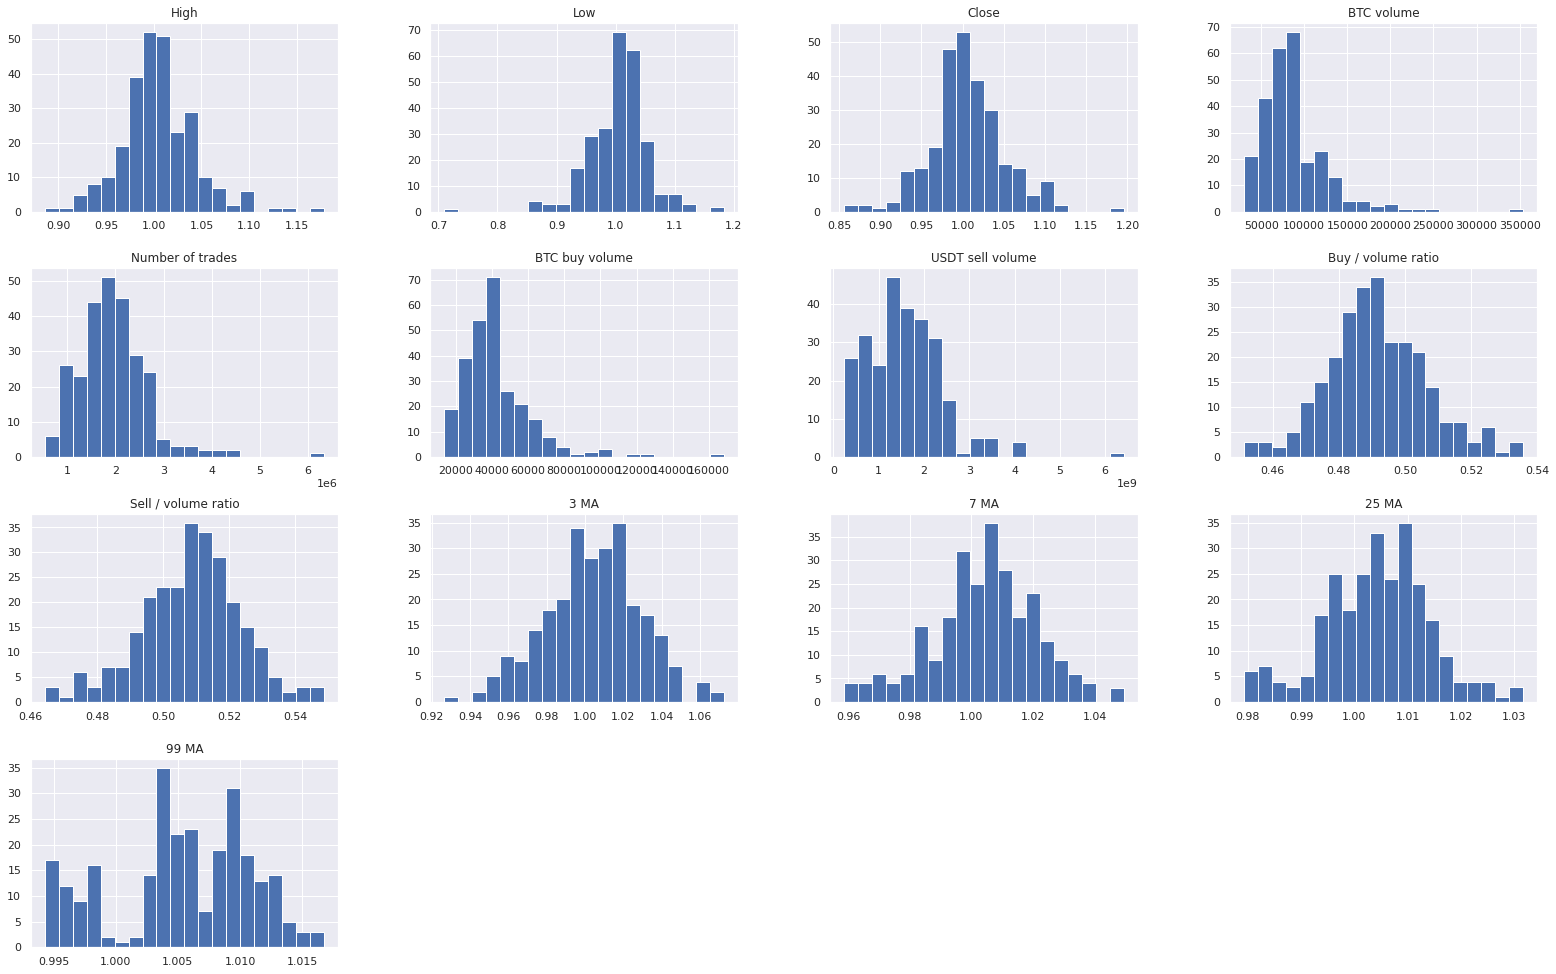

In [335]:
    def prepare_data(df):
        df = df.drop(columns=['Open time', 'Open', 'Close time', 'Ignore', 'USDT volume'])

        df['Buy / volume ratio'] = df['BTC buy volume'] / df['BTC volume']
        df['Sell / volume ratio'] = 1 - df['Buy / volume ratio']

        # MAs = (3, 7, 25, 99, 250)
        MAs = (3, 7, 25, 99)
        for avg in MAs:
            df[f'{avg} MA'] = df['Close'].rolling(avg).mean()

        for attr in ('High', 'Low', 'Close') + tuple(f'{avg} MA' for avg in MAs):
            df[attr].iloc[1:] = (df[attr].iloc[1:] / df[attr].iloc[:-1].values)

        df = df.dropna()
        print(df)

        df.hist(bins=20, figsize=(27, 17))

        df = (df - df.min()) / (df.max() - df.min())




        return df.to_numpy()

    take = 180

    data = pd.read_csv(google_drive_dir + 'data/' + '1d_1y.csv')
    history = data.iloc[-take:]
    data = prepare_data(data)[-take:]

    print(history)
    print(data)
    print(data.shape)
    print(len(history))




In [336]:
def get_state(data, t, n):
    return data[t-n+1:t+1]

In [337]:
window_size = 30

In [338]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(self, weights, reward_function, population_size, sigma, lr):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.lr = lr

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def get_lr(self, epoch):
        # self.lr *= .95
        return self.lr

    def get_sigma(self, epoch):
        # self.sigma *= .95
        return self.sigma


    def train(self, epochs = 100, print_every = 1):
        self.epochs = epochs
        lasttime = time.time()

        best_fitness = float('-inf')
        best_weights = None

        for epoch in range(epochs):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            if np.std(rewards) == 0:
                print(rewards)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.get_lr(epoch)
                    / (self.population_size * self.get_sigma(epoch))
                    * np.dot(A.T, rewards).T
                )

            rew = self.reward_function(self.weights)
            if rew > best_fitness:
                best_fitness = rew
                best_weights = deepcopy(self.weights)

            if (epoch + 1) % print_every == 0:
                print('[ iter {:>4} ]   profit: {:<+.1f} %'.format(epoch+1, self.reward_function(self.weights)))
        print('time taken to train:', time.time() - lasttime, 'seconds')
        return best_weights


class Model:

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

    def relu(self, X):
        return np.maximum(X, 0)

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def number_of_parameters(self):
        parameters = 0
        for w in self.weights:
            parameters += w.size
        return parameters





class FullModel(Model):
    def __init__(self, window_size, features, layer_size, output_size):
        self.output_size = output_size
        self.features = features

        self.weights = []

        for _ in range(features):
            self.weights.append(np.random.randn(window_size, layer_size)) # main weights
            self.weights.append(np.random.randn(1, layer_size)) # bias
            self.weights.append(np.random.randn(layer_size, output_size)) # decision weights
            self.weights.append(np.random.randn(layer_size, 1)) # buy weights

        self.weights.append(np.random.randn(features)) # decision feature importance weights
        self.weights.append(np.random.randn(features)) # buy feature importance weights



    def predict(self, inputs):
        decision = np.zeros((1, self.output_size))
        buy = 0

        for i, feature in enumerate(inputs.T):
            idx = 4 * i
            feed = self.sigmoid(feature @ self.weights[idx] + self.weights[idx + 1])
            decision += feed @ self.weights[idx + 2] * self.weights[-2][i]
            buy += feed @ self.weights[idx + 3] * self.weights[-1][i]

        decision, buy = decision / self.features, buy / self.features
        return decision, buy



class CloseOnlyModel(Model):
    def __init__(self, window_size, layer_size, output_size):
        self.output_size = output_size

        self.weights = []

        self.weights.append(np.random.randn(window_size, layer_size)) # main weights
        self.weights.append(np.random.randn(1, layer_size)) # bias
        self.weights.append(np.random.randn(layer_size, output_size)) # decision weights
        self.weights.append(np.random.randn(layer_size, 1)) # buy weights


    def predict(self, inputs):
        feature = inputs.T[2]
        feed = self.sigmoid(feature @ self.weights[0] + self.weights[1])
        decision = feed @ self.weights[2]
        buy = feed @ self.weights[3]

        return decision, buy

# agent

In [339]:
class Agent:


    def __init__(self, model, money, population_size=15, sigma=.3, lr=.03):
        self.model = model
        self.initial_money = money
        # self.max_buy = max_buy
        # self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            population_size,
            sigma,
            lr,
        )

    def act(self, data):
        decision, buy = self.model.predict(data)
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights, print_trades=False):
        ballance = starting_money = self.initial_money 
        self.model.weights = weights
        quantity = 0
        for t in range(window_size, len(data)):
            state = get_state(data, t, window_size)
            action, buy = self.act(state)
            price = history['Close'].iloc[t]
            if action == 1 and ballance > 0:
                quantity += ballance / price
                ballance = 0
            elif action == 2 and quantity > 0:
                ballance += quantity * price
                quantity = 0

        ballance += quantity * price
        profit = ((ballance - starting_money) / starting_money) * 100
        if not profit:
            profit = -100
        profit += random.random() / 100

        return profit

    def fit(self, epochs, print_every):
        weights = self.es.train(epochs, print_every=print_every)
        self.model.set_weights(weights)

    def simulate(self):
        ballance = starting_money = self.initial_money 
        states_sell = []
        states_buy = []
        quantity = 0
        for t in range(window_size, len(data)):
            state = get_state(data, t, window_size)
            action, buy = self.act(state)
            price = history['Close'].iloc[t]
            if action == 1 and ballance > 0:
                quantity += ballance / price
                ballance = 0
                states_buy.append(t)
                print('BUY  day {:>3}  ballance {:<10.1f}'.format(t, ballance + quantity*price))
            elif action == 2 and quantity > 0:
                ballance += quantity * price
                quantity = 0
                states_sell.append(t)
                print('SELL day {:>3}  ballance {:<10.1f}'.format(t, ballance + quantity*price))

        print(ballance, quantity, price, t)
        ballance += quantity * price
        print(ballance)
        interest = ((ballance - starting_money) / starting_money) * 100
        print(f'interest {interest:.1f} %')
        plt.figure(figsize = (20, 10))
        plt.plot(history['Close'], label = 'true close', c = 'g')
        plt.plot(history['Close'], 'X', label = 'predict buy', markevery = states_buy, c = 'b')
        plt.plot(history['Close'], 'o', label = 'predict sell', markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

# test

In [341]:
model = CloseOnlyModel(window_size=window_size, layer_size=500, output_size=3)
# model = FullModel(window_size=window_size, features=14, layer_size=500, output_size=3)
print(f'model has {model.number_of_parameters()} parameters')
agent = Agent(model, money=10**5, population_size=50, sigma=.3, lr=.03)
agent.fit(epochs=500, print_every=10)

model has 17500 parameters
[ iter   10 ]   profit: +40.0 %
[ iter   20 ]   profit: -19.6 %
[ iter   30 ]   profit: +11.3 %
[ iter   40 ]   profit: +12.6 %
[ iter   50 ]   profit: +33.1 %
[ iter   60 ]   profit: +45.4 %
[ iter   70 ]   profit: +23.3 %
[ iter   80 ]   profit: +14.1 %
[ iter   90 ]   profit: +53.3 %
[ iter  100 ]   profit: +80.1 %
[ iter  110 ]   profit: +110.9 %
[ iter  120 ]   profit: +104.6 %
[ iter  130 ]   profit: +108.2 %
[ iter  140 ]   profit: +105.7 %
[ iter  150 ]   profit: +124.3 %
[ iter  160 ]   profit: +116.9 %
[ iter  170 ]   profit: +136.0 %
[ iter  180 ]   profit: +134.2 %
[ iter  190 ]   profit: +132.8 %
[ iter  200 ]   profit: +145.4 %
[ iter  210 ]   profit: +141.5 %
[ iter  220 ]   profit: +147.4 %
[ iter  230 ]   profit: +131.1 %
[ iter  240 ]   profit: +148.1 %
[ iter  250 ]   profit: +174.8 %
[ iter  260 ]   profit: +148.5 %
[ iter  270 ]   profit: +127.7 %
[ iter  280 ]   profit: +215.3 %
[ iter  290 ]   profit: +218.4 %
[ iter  300 ]   profit: +1

In [342]:
agent.get_reward(agent.model.weights)

322.7247400235194

BUY  day  31  ballance 100000.0  
SELL day  32  ballance 98627.6   
BUY  day  33  ballance 98627.6   
SELL day  36  ballance 112222.4  
BUY  day  37  ballance 112222.4  
SELL day  38  ballance 115372.3  
BUY  day  40  ballance 115372.3  
SELL day  41  ballance 117225.2  
BUY  day  42  ballance 117225.2  
SELL day  43  ballance 115240.8  
BUY  day  44  ballance 115240.8  
SELL day  48  ballance 125845.9  
BUY  day  50  ballance 125845.9  
SELL day  52  ballance 131576.6  
BUY  day  53  ballance 131576.6  
SELL day  54  ballance 137880.5  
BUY  day  55  ballance 137880.5  
SELL day  56  ballance 142624.3  
BUY  day  60  ballance 142624.3  
SELL day  62  ballance 151108.5  
BUY  day  63  ballance 151108.5  
SELL day  64  ballance 152109.5  
BUY  day  70  ballance 152109.5  
SELL day  72  ballance 165523.3  
BUY  day  73  ballance 165523.3  
SELL day  74  ballance 171036.5  
BUY  day  77  ballance 171036.5  
SELL day  78  ballance 171705.2  
BUY  day  79  ballance 171705.2  
SELL day  82  

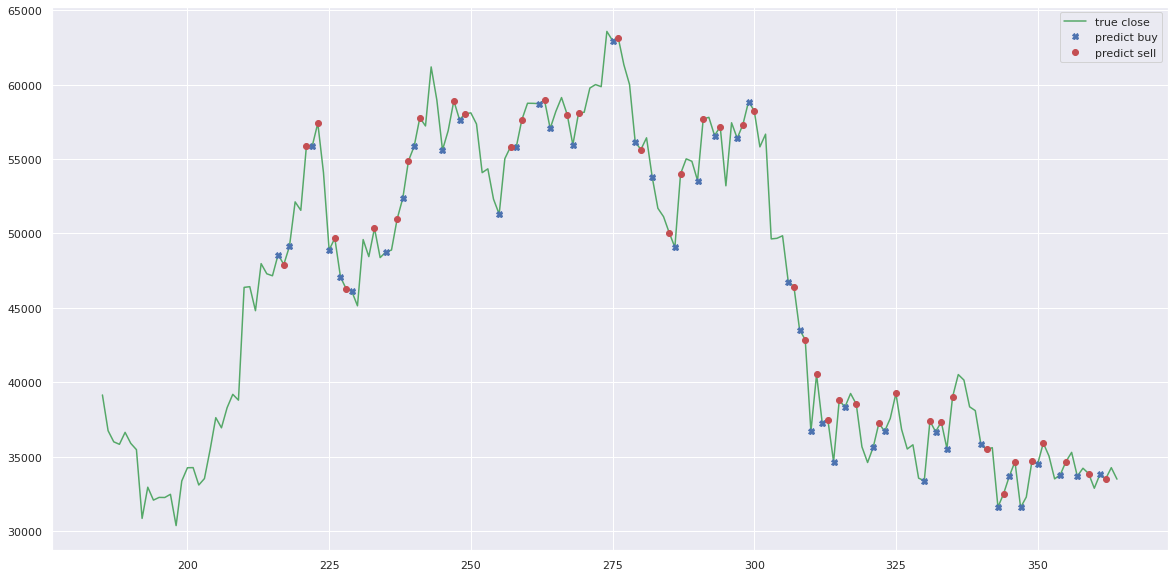

In [343]:
agent.simulate()